In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import re
import json
import time
import torch
import random
import transformers
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch import nn,optim
import nltk
# Uncomment to download "stopwords"
from nltk.corpus import stopwords

from sklearn.utils import shuffle
from transformers import BertTokenizer

from torch.utils.tensorboard import SummaryWriter  
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, precision_score,recall_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./input\sample_submission.csv
./input\test.csv
./input\train.csv


In [2]:
def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r"\'m", " am", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?' and ','
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?\,]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
#     s = " ".join([word for word in s.split()
#                   if word not in stopwords.words('english')
#                   or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [3]:
#stopwords.words('english')

In [4]:
s = 'i am not happy whit you now'
s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
s

'not happy whit'

In [6]:
train = pd.read_csv('./input/train.csv')
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
train['text_preprocessing'] = train['text'].apply(text_preprocessing)

In [8]:
train.head(10)

,id,keyword,location,text,target,text_preprocessing
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy 20 closed in b...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain causes flash floodin...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,i am on top of the hill and i can see a fire i...
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,there s an emergency evacuation happening now ...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,i am afraid that the tornado is coming to our ...


In [9]:
len(train[train['target']==1]),len(train[train['target']==0]),len(train[train['keyword']!=np.nan])

(3271, 4342, 7613)

In [10]:
test = pd.read_csv('./input/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
test['text_preprocessing'] = test['text'].apply(text_preprocessing)
test.head()

,id,keyword,location,text,text_preprocessing
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","heard about earthquake is different cities, st..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


In [12]:

sample_submission = pd.read_csv('./input/sample_submission.csv')
len(sample_submission),len(test)

(3263, 3263)

In [13]:
len(sample_submission[sample_submission['target']==1]),len(sample_submission[sample_submission['target']==0])

(0, 3263)

In [14]:
sents = []
for text,label in zip(train['text_preprocessing'].values,train['target'].values):
    dic_tmp ={"sent": text,'label':label}
    sents.append(dic_tmp)
len(sents)
sents[0]

{'sent': 'our deeds are the reason of this earthquake may allah forgive us all',
 'label': 1}

In [15]:
train_data,val_data = train_test_split(sents,test_size=0.1, random_state=2022)
len(train_data),len(val_data)

(6851, 762)

In [16]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True,cache_dir=os.path.join(os.getcwd(),"bert-base-uncased_cache"))


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent['sent'], add_special_tokens=True) for sent in sents]
# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  78


In [18]:
# specify a MAX_LEN you like
MAX_LEN=64

In [19]:
def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print('Device name:', torch.cuda.get_device_name(0))

    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    return device
device = get_device()

No GPU available, using the CPU instead.


In [20]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    token_type_ids= []
    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent["sent"].lower(),#The first sequence to be encoded
            #text_pair=text_preprocessing_data2(sent["sent2"].lower()),# second sequence to be encoded
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            truncation=True,
            return_token_type_ids=True,
#             return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
        token_type_ids.append(encoded_sent.get('token_type_ids'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    token_type_ids =  torch.tensor(token_type_ids)
    return input_ids, attention_masks, token_type_ids

In [21]:
#Convert  labels to torch.Tensor
train_labels = torch.tensor([t["label"] for t in train_data])
val_labels = torch.tensor([t["label"] for t in val_data])
train_labels,val_labels

(tensor([0, 0, 1,  ..., 1, 1, 0]),
 tensor([1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
         0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
         0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
         0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
         0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
         1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
         0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,

In [22]:
torch.count_nonzero(train_labels).item(),len(train_labels)-torch.count_nonzero(train_labels).item()

(2953, 3898)

In [23]:
torch.count_nonzero(val_labels).item(),len(val_labels)-torch.count_nonzero(val_labels).item()

(318, 444)

In [24]:
train_inputs, train_masks , train_token_type_ids = preprocessing_for_bert(train_data)
val_inputs, val_masks ,val_token_type_ids= preprocessing_for_bert(val_data)

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
#Create PyTorch DataLoader

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks,train_token_type_ids, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_token_type_ids,val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [26]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        # bert base 768 hidden dimension
        # bert large 1024 hidden dimension
        D_in, H, D_out = 768, 64, 2
        unfreeze_layers = ['layer.10','layer.11','bert.pooler','out.']
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
#             for name, param in self.bert.named_parameters():
#                 print(name,param.size())
 
#             print("*"*30)
#             print('\n')
 
            for name ,param in self.bert.named_parameters():
                param.requires_grad = False
                for ele in unfreeze_layers:
                    if ele in name:
                        param.requires_grad = True
                        break
#             #验证一下
#             for name, param in self.bert.named_parameters():
#                 if param.requires_grad:
#                     print(name,param.size())

        
    def forward(self, input_ids, attention_mask, token_type_ids):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            token_type_ids=token_type_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Wall time: 1.97 ms


In [27]:
def get_scheduler(optimizer, scheduler: str, warmup_steps: int, t_total: int):
        """
        Returns the correct learning rate scheduler
        """
        scheduler = scheduler.lower()
        if scheduler == 'constantlr':
            return transformers.get_constant_schedule(optimizer)
        elif scheduler == 'warmupconstant':
            return transformers.get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)
        elif scheduler == 'warmuplinear':
            return transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)
        elif scheduler == 'warmupcosine':
            return transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)
        elif scheduler == 'warmupcosinewithhardrestarts':
            return transformers.get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)
        else:
            raise ValueError("Unknown scheduler {}".format(scheduler))


In [28]:
len_train_step = len(train_dataloader)
print('len_train_step: ',len_train_step)

def initialize_model(epochs=3,fp16=False,n_gpu=0,local_rank=-1):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    # bert_layers越小，学习率应该要越大
    #optimizer = AdamW(bert_classifier.parameters(),
    #                  lr=5e-5,    # Default learning rate
    #                 eps=1e-8    # Default epsilon value
    #                  )
    # 定义优化器
    optimizer = optim.Adam(
                            bert_classifier.parameters(),
                            lr=2e-5,
                            betas=(0.9, 0.999),
                            eps=1e-08,
                            weight_decay=0,
                            amsgrad=False)# Adam梯度下降
    # Total number of training steps
    total_steps = len_train_step * epochs
    warm_up_ratio = 0.0 # 定义要预热的step
    # Set up the learning rate scheduler
    # https://blog.csdn.net/orangerfun/article/details/120400247
    #scheduler = get_linear_schedule_with_warmup(optimizer,
    #                                           num_warmup_steps=warm_up_ratio*total_steps, # Default value
    #                                            num_training_steps=total_steps)
    scheduler = get_scheduler(optimizer, 'warmuplinear', warm_up_ratio*total_steps, total_steps)
    #### Optional configuration
#     if fp16:"Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit"
#         try:
#             from apex import amp
#             fp16_opt_level = '01'
#         except ImportError:
#             raise ImportError("Please install apex from "
#             "https://www.github.com/nvidia/apex to use fp16 training.")
#         bert_classifier, optimizer = amp.initialize(
#             bert_classifier, optimizer, opt_level=fp16_opt_level)
#         "For fp16: Apex AMP optimization level "
#         "selected in ['O0', 'O1', 'O2', and 'O3']."
#         "See details at https://nvidia.github.io/apex/amp.html"
#     # multi-gpu training (should be after apex fp16 initialization)
#     if n_gpu > 1:
#         bert_classifier = torch.nn.DataParallel(bert_classifier)
        
#      # Distributed training (should be after apex fp16 initialization)
#     if local_rank != -1:
#         bert_classifier = torch.nn.parallel.DistributedDataParallel(
#             bert_classifier, 
#             device_ids=[local_rank],
#             output_device=local_rank,
#             find_unused_parameters=True
#             )
        
    return bert_classifier, optimizer, scheduler


len_train_step:  429


In [29]:
# Specify loss function
# loss_fn = nn.CrossEntropyLoss(reduction='mean',label_smoothing=0.05)
loss_fn = nn.CrossEntropyLoss(reduction='mean')#https://blog.csdn.net/zyoung17/article/details/108430465
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    one_cricle_length = len(train_dataloader)
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val F1':^9} | {'Elapsed/lr':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask,b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids,b_token_type_ids, b_attn_mask)
#             print('logits,b_labels')
#             print(logits)
#             print(b_labels)
            '''tensor([[-0.0491,  0.1918],
                       [-0.0062,  0.1743],
                       [-0.0856,  0.2257],
                       [-0.0044,  0.1629]], grad_fn=<AddmmBackward>)
                tensor([0, 1, 0, 0])
            '''
            #print(logits.shape)  #torch.Size([4, 2]), 4是batch_size, 2是类别
            #print(b_labels.shape) #torch.Size([4])
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            #print(loss)
            #print(logits.shape,b_labels.shape,loss.shape)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()
#             b = 0.64
#             flood = (loss-b).abs()+b
#             flood.backward()
            
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients",L2 norm fuc
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0, norm_type=2)

            # Update parameters and the learning rate
            op_params =optimizer.state_dict()['param_groups'][0]
            lr = op_params.get('lr')
            
            ########################################################################
            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                #writer.add_scalar('step/train_loss_step', batch_loss / batch_counts, step + epoch_i*one_cricle_length)
                #writer.add_scalar('step/train_lr_step', lr, step + epoch_i*one_cricle_length)

                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
#                 writer.add_scalar('steploss/train_loss_step', batch_loss / batch_counts, step)
                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {lr}")
                
                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
            ###############################################################
            optimizer.step()
            scheduler.step()
        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_f1, val_accuracy, val_p1, val_r1 = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            #writer.add_scalar('loss/train_loss', avg_train_loss, epoch_i)
            #writer.add_scalar('loss/val_loss', val_loss, epoch_i)
            #writer.add_scalar('matrix/val_f1', val_f1, epoch_i)
            #writer.add_scalar('matrix/val_p1', val_p1, epoch_i)
            #writer.add_scalar('matrix/val_r1', val_r1, epoch_i)
            #writer.add_scalar('matrix/val_accuracy', val_accuracy, epoch_i)
            
            print(f"{val_r1:^9.2f} | {val_p1:^9.2f} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_f1:^9.2f} | {val_accuracy:^9.2f}")
            print("-"*70)
        print("\n")
    #writer.close()
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    val_f1 = []
    val_p0,val_p1,val_r0,val_r1 = [],[],[],[]

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids,b_token_type_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        #print(preds)
        #print(b_labels)
        # Calculate the accuracy rate
        # accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        #accuracy = (preds == b_labels).cpu().numpy().mean()
        accuracy = accuracy_score(b_labels, preds,  normalize=True)
        f1 = f1_score(b_labels, preds, average='weighted')
        precision = precision_score(b_labels, preds, average='weighted')
        recall = recall_score(b_labels, preds, average='weighted')
        val_f1.append(f1)
        val_accuracy.append(accuracy)
        val_p1.append(precision)
        val_r1.append(recall)
    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_f1 = np.mean(val_f1)
    val_accuracy = np.mean(val_accuracy)
    val_p0 = np.mean(val_p0)
    val_p1 = np.mean(val_p1)
    val_r0 = np.mean(val_r0)
    val_r1 = np.mean(val_r1)

    return val_loss, val_f1, val_accuracy,val_p1,val_r1

In [30]:
epochs=3
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=epochs)
print('len_train_step: ',len_train_step)
train(bert_classifier, train_dataloader, val_dataloader, epochs=epochs, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


len_train_step:  429
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val F1   | Elapsed/lr
----------------------------------------------------------------------
   1    |   20    |   0.608962   |     -      |     -     | 1.9689199689199693e-05
   1    |   40    |   0.520967   |     -      |     -     | 1.937839937839938e-05
   1    |   60    |   0.491192   |     -      |     -     | 1.906759906759907e-05
   1    |   80    |   0.497113   |     -      |     -     | 1.875679875679876e-05
   1    |   100   |   0.469459   |     -      |     -     | 1.8445998445998446e-05
   1    |   120   |   0.450308   |     -      |     -     | 1.8135198135198137e-05
   1    |   140   |   0.402150   |     -      |     -     | 1.7824397824397825e-05
   1    |   160   |   0.353954   |     -      |     -     | 1.7513597513597516e-05
   1    |   180   |   0.457764   |     -      |     -     | 1.7202797202797203e-05
   1    |   200   |   0.451337   |     -      |     -     | 1.689199689199

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0.83    |   0.85    |   0.443335   |  0.422439  |   0.83    |   0.83   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val F1   | Elapsed/lr
----------------------------------------------------------------------
   2    |   20    |   0.340076   |     -      |     -     | 1.3022533022533024e-05
   2    |   40    |   0.333349   |     -      |     -     | 1.2711732711732714e-05
   2    |   60    |   0.329872   |     -      |     -     | 1.2400932400932401e-05
   2    |   80    |   0.291647   |     -      |     -     | 1.2090132090132092e-05
   2    |   100   |   0.377714   |     -      |     -     | 1.177933177933178e-05
   2    |   120   |   0.358922   |     -      |     -     | 1.1468531468531469e-05
   2    |   140   |   0.307628   |     -      |     -     | 1.1157731157731158e-05
   2    |   160   |   0.320227   |     -      |     -     | 1.0846930846930847e-05
   2    |   180   |   0.330876   |     -      | 

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0.84    |   0.85    |   0.329207   |  0.416686  |   0.84    |   0.84   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val F1   | Elapsed/lr
----------------------------------------------------------------------
   3    |   20    |   0.238475   |     -      |     -     | 6.355866355866357e-06
   3    |   40    |   0.219420   |     -      |     -     | 6.045066045066046e-06
   3    |   60    |   0.256740   |     -      |     -     | 5.7342657342657345e-06
   3    |   80    |   0.290869   |     -      |     -     | 5.423465423465424e-06
   3    |   100   |   0.304523   |     -      |     -     | 5.112665112665113e-06
   3    |   120   |   0.287566   |     -      |     -     | 4.801864801864802e-06
   3    |   140   |   0.231360   |     -      |     -     | 4.4910644910644915e-06
   3    |   160   |   0.290222   |     -      |     -     | 4.180264180264181e-06
   3    |   180   |   0.306220   |     -      |     -

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        #b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids,b_token_type_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [32]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) 
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8988
Accuracy: 83.86%


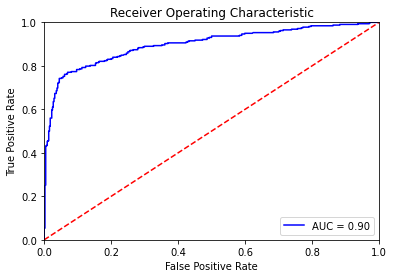

In [33]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, val_labels)

In [34]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [35]:
test.head()

,id,keyword,location,text,text_preprocessing
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","heard about earthquake is different cities, st..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


In [36]:
test_data = []
for sent  in test.text_preprocessing.values:
    test_data.append({'sent':sent,"label":0})
test_inputs, test_masks , test_token_type_ids = preprocessing_for_bert(test_data)
test_labels = torch.tensor([t["label"] for t in test_data])
# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_token_type_ids,test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [37]:
probs = bert_predict(bert_classifier, test_dataloader)
preds = probs[:, 1]
y_pred = np.where(preds >= 0.5, 1, 0)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [38]:
sample_submission['target']=y_pred
sample_submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [39]:
sample_submission.to_csv('./output/submission.csv')